In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy as cy
import cartopy.crs as ccrs
import matplotlib.path as mpath



In [2]:
def circle_for_polar_map(axes):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_boundary(circle, transform=axes.transAxes)

In [4]:
AR_2020_file = 'AR_detection_2020.nc4'
data_dir = '/home/jovyan/Tjaernoe2022-group5/data'
ar_2020 = xr.open_dataset(os.path.join(data_dir,AR_2020_file))

In [6]:
AR_comp_file = '20002015_AR_detection.nc'
ar_comp = xr.open_dataset(AR_comp_file)

In [114]:
ar_2020.sel(time='2020-04-15T12:00:00')#[836]

<xarray.Dataset>
Dimensions:        (lat: 361, lon: 576)
Coordinates:
  * lat            (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon            (lon) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
    time           datetime64[ns] 2020-04-15T12:00:00
Data variables:
    ar_binary_tag  (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    CDI:          Climate Data Interface version 2.0.0rc2 (https://mpimet.mpg...
    Conventions:  CF-1.6
    description:  ARTMIP file format (Ullrich)
    history:      Tue May  3 12:22:37 2022: ncks -4 -L 1 temp_MERRA2.ar_tag.W...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.0.0rc4 (https://mpimet.mpg...

In [104]:
val_2020 = ar_2020['ar_binary_tag'].values[:]*1.0

In [112]:
np.unique(val_2020[844,:,:]) #val_2020[844,:,:]

array([0., 1.])

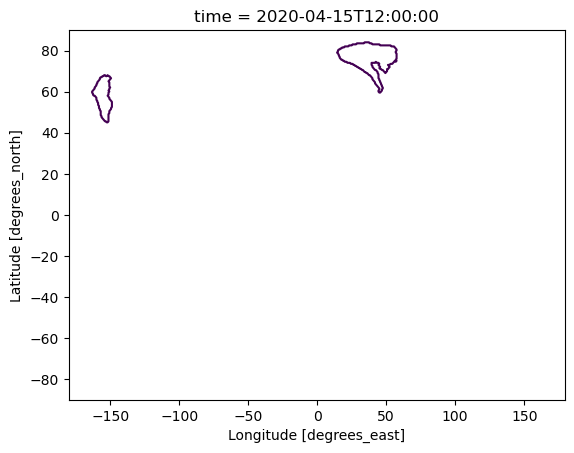

In [122]:
t = xr.plot.contour(ar_2020.sel(time='2020-04-15T12:00:00').ar_binary_tag, levels=[0.0,1.0])
#plt.colorbar()
#plt.close()

In [32]:
len(t.collections)

1

In [ ]:
for tt in range(len(out_ar.time)):
    df_loc = test_val[:,tt,:]
    ll = plt.contour(df_loc,levels=[0,1])
    plt.close()

In [56]:
day='2020-04-15'
ar_1day = ar_2020['ar_binary_tag'].sel(time=day).mean(dim='time').squeeze()

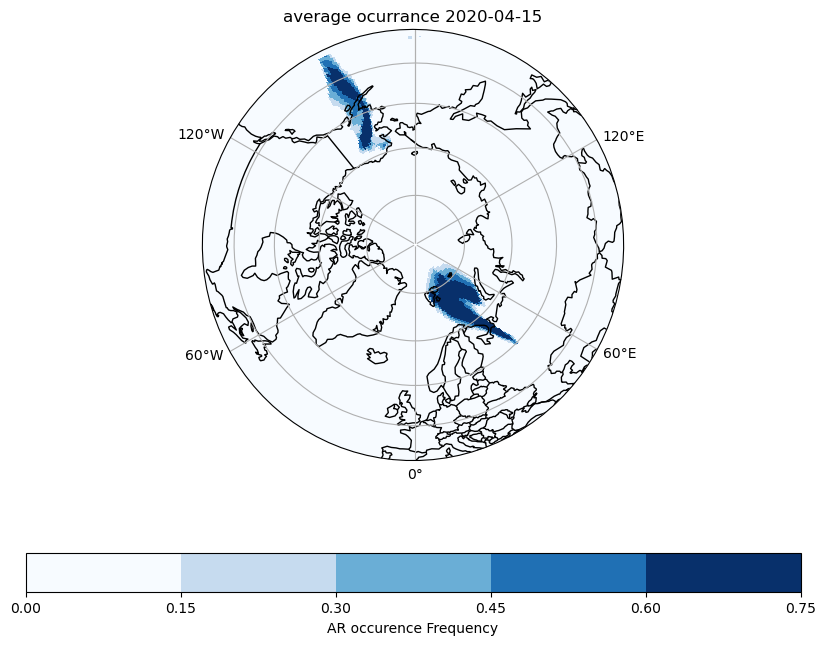

In [57]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
ar_1day.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'AR occurence Frequency', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
ax.set_title('average ocurrance {0}'.format(day))
ax.coastlines()
circle_for_polar_map(ax)
ax.set_extent([0, 360, 40, 90], ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.add_feature(cy.feature.BORDERS);

In [50]:
ar_sub = ar_2020.sel(time=slice('2020-04-14','2020-04-17'))

In [51]:
ar_sub_zep = ar_sub.sel(lat=78.9, lon = 11.8, method='nearest').squeeze()

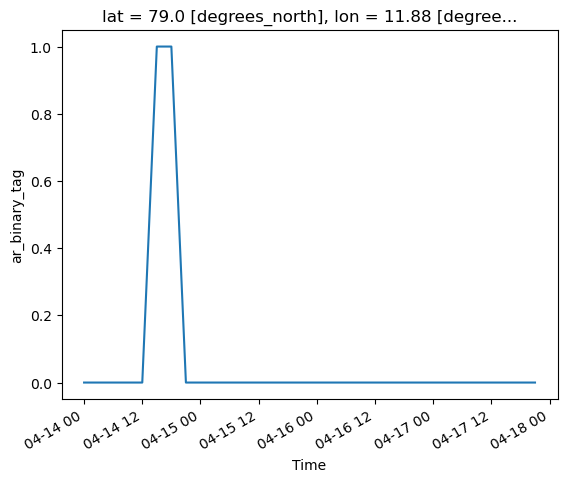

In [52]:
ar_sub_zep['ar_binary_tag'].plot()